<a href="https://colab.research.google.com/github/LazaroR-u/Thesis_Data_Analysis_CMS_CERN/blob/main/3_New_Currents_Distributions_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of the currents in the RPCs of the CMS detector at CERN.

By **Lázaro R. Díaz Lievano**

**B.Sc. Physics Student, Autonomous University of Puebla.**


This study builds upon the analysis conducted by Mapse Ferreira.

In our approach, we introduce the following enhancements:

1. **Updated Mapping Dataframe:** We have generated a new mapping dataframe from the RPC label change history data, incorporating information for 1056 chambers and their respective HV DPIDs. In contrast, the Mapse mapping dataframe comprises only 1050 chambers, leaving six chambers unaccounted for.

2. **Enhanced Mapping Function:** We have developed a new mapping function that takes into consideration both chamber names for duplicate DPIDs. In comparison, the Mapse mapping function only provides one chamber name for duplicate DPIDs. This improvement allows for a more comprehensive and accurate mapping of chamber data, specially, in the entries of the histograms for the Endcap region.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import numpy as np

In [2]:
def convert_dpid_name(df_data, df_mapping):

    # Take df colums to numpy array
    k = df_mapping['DPID2'].to_numpy()
    v = df_mapping['CHAMBER_NAME'].to_numpy()

    # Convert both arrays to a dict.
    dicmap =  dict(zip(k, v))

    # Takes the chamber names from the mapping file and add it in a new column
    # to the data dataframe
    df_data['Chamber_name'] = df_data['DPID'].map(dicmap)

    df_data_mapped = df_data

    return df_data_mapped

In [3]:
def individual_wheel(wheel, voltage, df_data):

    # Filter for select the wished voltage
    df_data = df_data[(df_data.V_APPLIED == voltage)]

    # Filter for select the wished wheel
    df_wheel = df_data[np.where(df_data['Chamber_name'].str.find(wheel) == 0, True, False) == True]
    #just return the wheel
    return df_wheel

In [4]:
def select_endcap(region, voltage, df_data):

    # Filter for select the wished voltage
    df_data = df_data[(df_data.V_APPLIED == voltage)]

    # Filter for select the wished endcap
    df_endcap = df_data[np.where(df_data['Chamber_name'].str.find(region) == 0, True, False) == True]

    '''if region == 'RE-' or region =='RE+':
        df_endcap = df_data[np.where(df_data['Chamber_name'].str.find(region) == 0, True, False) == True]
        df_endcap = df_endcap[np.where(df_endcap['Chamber_name'].str.find('RE+4') != 0, True, False) == True]
        df_endcap = df_endcap[np.where(df_endcap['Chamber_name'].str.find('RE-4') != 0, True, False) == True]
    else:
        df_endcap = df_endcap[np.where(df_endcap['Chamber_name'].str.find('RE+4') == 0, True, False) == True]
        df_endcap = df_endcap[np.where(df_endcap['Chamber_name'].str.find('RE-4') != 0, True, False) == True]'''

    return df_endcap

In [5]:
def filter_current_data(data_required, date):

    df_date_to_plot = data_required[np.where(data_required['DATE'].str.find(date) == 0, True, False) == True]
    df_current = df_date_to_plot['AVG_IMON']

    return df_current

In [6]:
def plot(data_to_plot, dates_array, bins=80):
    #define an array of specific colors
    colors = np.array(['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#449166','#6d9509','#1f465e'])
    handles = []
    labels = []
    #create a figure of subplots
    fig, ax = plt.subplots()

    for i, j in enumerate(dates_array):
        #filter the data to return only entries with the desired date
        df_date_to_plot = data_to_plot[np.where(data_to_plot['DATE'].str.find(j) == 0, True, False) == True]
        df_current = df_date_to_plot['AVG_IMON']
        #if the mean current in this date is a nan then print there is not data available, else pass
        if np.isnan(round(df_current.mean(),2)):
            print(f"There is no data available for: {j}")
            continue
        #creates a mean currents histogram
        histogr = df_current.plot.hist(bins=bins, alpha=1.0, color=colors[i],  histtype='step', linewidth=2, range=(0, 20))

        handles.append(Rectangle((0,0), 1, 1, color=colors[i], ec="k"))
        labels.append(j + f"-mean: {round(df_current.mean(),2)} uA")


    # Xlabel
    ax.xaxis.set_label_coords(0.90, -0.055)
    ax.set_xlabel(r'$I(\mu A)$', fontsize = 22)

    # Ylabel
    ax.yaxis.set_label_coords(-0.09, 0.86)
    ax.set_ylabel('Entries', fontsize = 22)

    #print this objects in the plot
    plt.legend(handles, labels)

    # CMS format
    hfont = {'fontname':'italic'}
    plt.text(0.13, 0.89, "CMS", fontdict=hfont,  fontweight='bold', transform=plt.gcf().transFigure)
    plt.text(0.23, 0.89, "Preliminary", fontdict=hfont, style='italic',fontsize = 22, transform=plt.gcf().transFigure)

    plt.grid()

    ## Takes the first element column chamber name in order to save with the correct name
    # This works for W+-2 and W+-1
    name = data_to_plot['Chamber_name'].to_numpy()[1][0:3]
    # This works for
    if name[2] == '_':
        name = name[0:2]

    plt.savefig("Current_distribution_" + name +".png")

In [7]:
def cambia_ids_repetidos(df):
    id_count = {}

    def generar_sufijo(count):
        letras = 'abcdefghijklmnopqrstuvwxyz'
        sufijo = ''
        while count >= len(letras):
            sufijo += letras[count % len(letras)]
            count //= len(letras)
        sufijo += letras[count]
        return sufijo

    for index, row in df.iterrows():
        dpid = row['DPID2']
        if dpid in id_count:
            count = id_count[dpid]
            sufijo = generar_sufijo(count)
            id_count[dpid] += 1
            df.at[index, 'DPID2'] = f'{dpid}{sufijo}'
        else:
            id_count[dpid] = 1

    return df

def agregar_letra(indice):
    return f'{indice}a'


In [8]:
def convert_dpid_name_2(df_data, df_mapping_2):

    # Take df colums to numpy array
    k = df_mapping_2['DPID2'].to_numpy()
    v = df_mapping_2['CHAMBER_NAME'].to_numpy()

    # Convert both arrays to a dict.
    dicmap =  dict(zip(k, v))

    # Takes the chamber names from the mapping file and add it in a new column
    # to the data dataframe
    df_data['Chamber_name'] = df_data['DPID'].map(dicmap)

    df_data_mapped = df_data

    return df_data_mapped

#load data

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Transform the .csv in a panda dataframe
#have to download the csv from the link of the CERN
df_data = pd.read_csv('https://raw.githubusercontent.com/LazaroR-u/Thesis_Data_Analysis_CMS_CERN/main/last_data_2023.csv')

# New Mapping dataframe between dpid and chamber name
dfnew_mapping =  pd.read_csv("https://raw.githubusercontent.com/LazaroR-u/Thesis_Data_Analysis_CMS_CERN/main/df2_ultimo.csv")
dfnew_mapping = dfnew_mapping.rename(columns={'DPID': 'DPID2', 'Chamber_name': 'CHAMBER_NAME'})

df_data = df_data.dropna()
df_data['DPID'] = df_data['DPID'].astype(int)


If you want to know how dfnew_mapping was processed, check this notebook https://colab.research.google.com/drive/1QRlFbJaN-1FIB8_MFe4CL2mAuEDijTs1?usp=sharing

In [10]:
dfnew_mapping

,CHAMBER_NAME,DPID2
0,W+2_RB1in_S01,315
1,W+2_RB1out_S01,316
2,W+2_RB2in_S01,317
3,W+2_RB2out_S01,318
4,W+2_RB3-_S01,319
...,...,...
1051,RE-1_R3_CH04,216689
1052,RE-1_R3_CH10,216689
1053,RE-2_R2_CH11,216701
1054,RE-1_R2_CH18,216701


In [11]:
df_mapping_dup = dfnew_mapping[dfnew_mapping["DPID2"].duplicated(keep=False)]
df_mapping_dup

,CHAMBER_NAME,DPID2
481,RE+1_R3_CH29,142824
482,RE+2_R3_CH02,142824
483,RE+1_R3_CH31,142825
484,RE+1_R2_CH29,142825
485,RE+1_R3_CH35,142826
...,...,...
1048,RE+3_R2_CH33,216670
1051,RE-1_R3_CH04,216689
1052,RE-1_R3_CH10,216689
1053,RE-2_R2_CH11,216701


In [12]:
df_data[~df_data["DPID"].isin(dfnew_mapping["DPID2"])]

,DPID,DATE,START_DATE,STOP_DATE,V_APPLIED,AVG_IMON
24504,142816,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 04.32.22.000000000 PM,1000,0.2
24505,142816,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 04.33.02.000000000 PM,25-MAR-18 04.42.22.000000000 PM,2000,0.2
24506,142816,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 04.43.02.000000000 PM,25-MAR-18 04.52.21.000000000 PM,3000,0.2
24507,142816,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 04.53.01.000000000 PM,25-MAR-18 05.02.21.000000000 PM,4000,0.3
24508,142816,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 05.03.01.000000000 PM,25-MAR-18 05.12.20.000000000 PM,5000,0.3
...,...,...,...,...,...,...
41895,216672,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 06.32.17.000000000 PM,25-MAR-18 06.42.27.000000000 PM,9400,0.9
41896,216672,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 06.42.27.000000000 PM,25-MAR-18 06.52.16.000000000 PM,9500,0.9
41897,216672,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 06.52.16.000000000 PM,25-MAR-18 07.02.16.000000000 PM,9600,0.9
41898,216672,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 07.02.16.000000000 PM,25-MAR-18 07.12.25.000000000 PM,9700,0.9


There are data for different HV DPIDs that do not correspond to any chamber name.

In [13]:
df_data[~df_data["DPID"].isin(dfnew_mapping["DPID2"])]["DPID"].unique()

array([142816, 142817, 142818, 142819, 142820, 142821, 216671, 216672])

In [14]:
len(df_data[~df_data["DPID"].isin(dfnew_mapping["DPID2"])]["DPID"].unique())

8

In [15]:
#Mapse mapping dataframe
df_mapping = pd.read_csv('https://raw.githubusercontent.com/Mapse/RPC_Currents/main/RPC_Chamber_HV_Map.csv')
len(df_data[~df_data["DPID"].isin(df_mapping["DPID2"])]["DPID"].unique())

11

There are 8 DPIDs in df_data that do not exist in either the Mapse mapping dataframe or the new mapping dataframe.

If we use the Mapse mapping dataframe, we found 11 DPIDs missing.

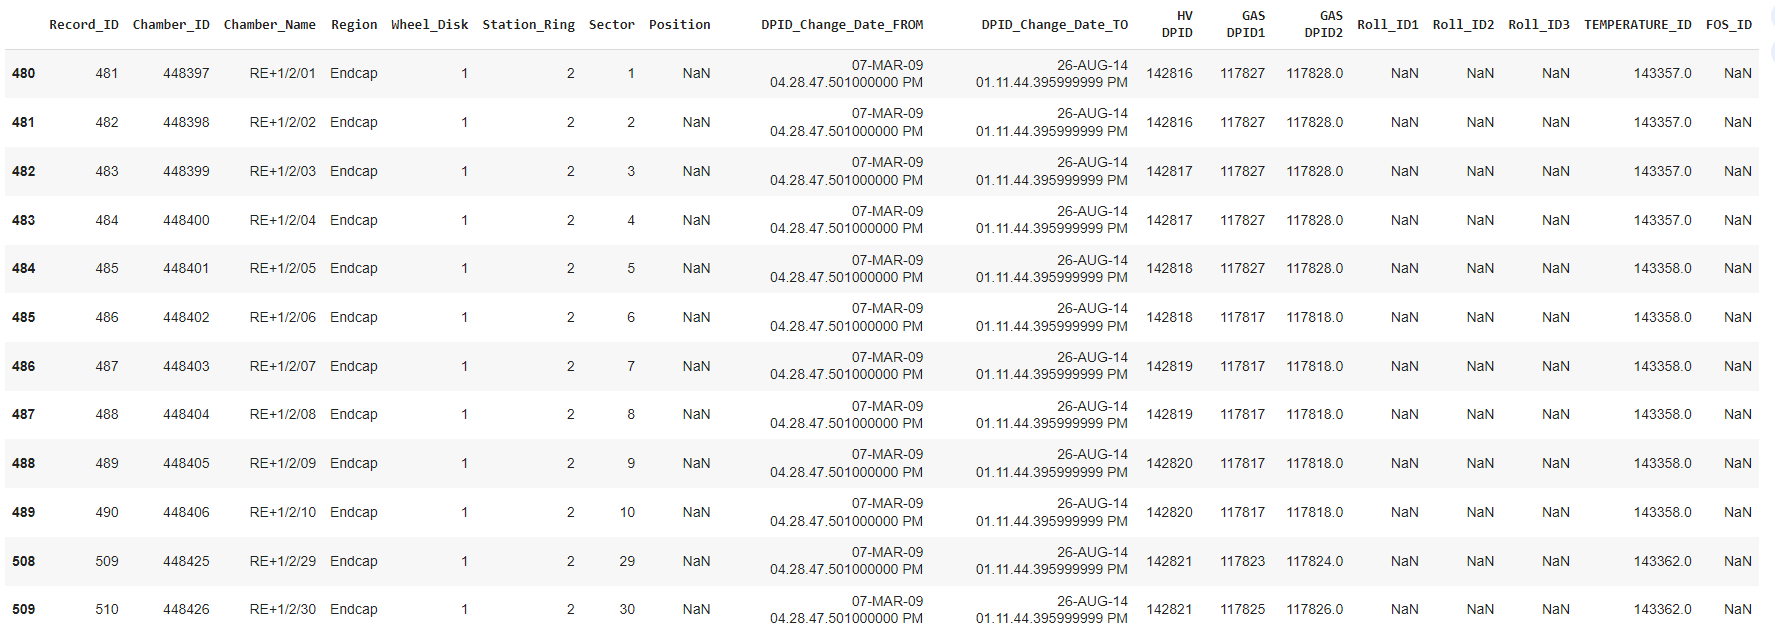

There are 6 DPIDs that correspond to 12 chamber names in the Label Change History RPCs data

In [16]:
df_data[df_data["DPID"].isin([142816, 142817, 142818, 142819, 142820, 142821, 216671, 216672])]

,DPID,DATE,START_DATE,STOP_DATE,V_APPLIED,AVG_IMON
24504,142816,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 04.32.22.000000000 PM,1000,0.2
24505,142816,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 04.33.02.000000000 PM,25-MAR-18 04.42.22.000000000 PM,2000,0.2
24506,142816,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 04.43.02.000000000 PM,25-MAR-18 04.52.21.000000000 PM,3000,0.2
24507,142816,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 04.53.01.000000000 PM,25-MAR-18 05.02.21.000000000 PM,4000,0.3
24508,142816,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 05.03.01.000000000 PM,25-MAR-18 05.12.20.000000000 PM,5000,0.3
...,...,...,...,...,...,...
41895,216672,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 06.32.17.000000000 PM,25-MAR-18 06.42.27.000000000 PM,9400,0.9
41896,216672,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 06.42.27.000000000 PM,25-MAR-18 06.52.16.000000000 PM,9500,0.9
41897,216672,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 06.52.16.000000000 PM,25-MAR-18 07.02.16.000000000 PM,9600,0.9
41898,216672,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 07.02.16.000000000 PM,25-MAR-18 07.12.25.000000000 PM,9700,0.9


# adding suffix to df mapping

In cases where a DPID is associated with multiple chambers, we assign unique DPIDs to each different chambers by appending a suffix "a" or "b".  This unique labeling helps us differentiate between chambers and ensures accurate analysis.
DPID multiplicity arises in the end caps region, consequently the data in df_data and the current distribution plots duplicate values.


In [17]:
df_mapping_2 = cambia_ids_repetidos(dfnew_mapping)
df_mapping_2['DPID2'] = df_mapping_2['DPID2'].apply(lambda x: agregar_letra(x) if x in df_mapping_dup['DPID2'].values else x)
df_mapping_2

<ipython-input-17-a6ae7f86e3f8>:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  df_mapping_2['DPID2'] = df_mapping_2['DPID2'].apply(lambda x: agregar_letra(x) if x in df_mapping_dup['DPID2'].values else x)


,CHAMBER_NAME,DPID2
0,W+2_RB1in_S01,315
1,W+2_RB1out_S01,316
2,W+2_RB2in_S01,317
3,W+2_RB2out_S01,318
4,W+2_RB3-_S01,319
...,...,...
1051,RE-1_R3_CH04,216689a
1052,RE-1_R3_CH10,216689b
1053,RE-2_R2_CH11,216701a
1054,RE-1_R2_CH18,216701b


# Process df data

## adding suffix to df data

In [18]:
df_data_map = pd.DataFrame(columns=df_data.columns)

for index, row in df_data.iterrows():
    dpid = row['DPID']

    if dpid in df_mapping_dup["DPID2"].values:
        nueva_fila_a = row.copy()
        nueva_fila_a['DPID'] = f'{dpid}a'
        df_data_map = df_data_map.append(nueva_fila_a, ignore_index=True)

        nueva_fila_b = row.copy()
        nueva_fila_b['DPID'] = f'{dpid}b'
        df_data_map = df_data_map.append(nueva_fila_b, ignore_index=True)
    else:

        df_data_map = df_data_map.append(row, ignore_index=True)

df_data_map

<ipython-input-18-df0ccdfd63c3>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data_map = df_data_map.append(row, ignore_index=True)
<ipython-input-18-df0ccdfd63c3>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data_map = df_data_map.append(nueva_fila_a, ignore_index=True)
<ipython-input-18-df0ccdfd63c3>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data_map = df_data_map.append(nueva_fila_b, ignore_index=True)


,DPID,DATE,START_DATE,STOP_DATE,V_APPLIED,AVG_IMON
0,315,27-JUL-18 12.42.10.000000000 PM,27-JUL-18 12.42.10.000000000 PM,27-JUL-18 12.51.32.000000000 PM,1000,0.0
1,315,27-JUL-18 12.42.10.000000000 PM,27-JUL-18 12.51.54.000000000 PM,27-JUL-18 01.01.32.000000000 PM,1500,0.0
2,315,27-JUL-18 12.42.10.000000000 PM,27-JUL-18 01.02.01.000000000 PM,27-JUL-18 01.11.33.000000000 PM,2000,0.0
3,315,27-JUL-18 12.42.10.000000000 PM,27-JUL-18 01.11.59.000000000 PM,27-JUL-18 01.21.35.000000000 PM,2500,0.0
4,315,27-JUL-18 12.42.10.000000000 PM,27-JUL-18 01.21.59.000000000 PM,27-JUL-18 01.31.34.000000000 PM,3000,0.0
...,...,...,...,...,...,...
88540,216701b,21-JUN-23 11.01.16.000000000 AM,21-JUN-23 01.00.59.000000000 PM,21-JUN-23 01.15.34.000000000 PM,9000,4.2
88541,216701a,21-JUN-23 11.01.16.000000000 AM,21-JUN-23 01.15.39.000000000 PM,21-JUN-23 01.30.27.000000000 PM,9200,4.6
88542,216701b,21-JUN-23 11.01.16.000000000 AM,21-JUN-23 01.15.39.000000000 PM,21-JUN-23 01.30.27.000000000 PM,9200,4.6
88543,216701a,21-JUN-23 11.01.16.000000000 AM,21-JUN-23 01.30.27.000000000 PM,21-JUN-23 04.35.27.000000000 PM,9400,4.6


## using the new map function to df data

This mapping considers the two chamber names in the duplicate DPIDs, and now we are using the mapping dataframe with 1056 chambers.

In [19]:
df_data_map = convert_dpid_name_2(df_data_map, df_mapping_2)
df_data_map

,DPID,DATE,START_DATE,STOP_DATE,V_APPLIED,AVG_IMON,Chamber_name
0,315,27-JUL-18 12.42.10.000000000 PM,27-JUL-18 12.42.10.000000000 PM,27-JUL-18 12.51.32.000000000 PM,1000,0.0,W+2_RB1in_S01
1,315,27-JUL-18 12.42.10.000000000 PM,27-JUL-18 12.51.54.000000000 PM,27-JUL-18 01.01.32.000000000 PM,1500,0.0,W+2_RB1in_S01
2,315,27-JUL-18 12.42.10.000000000 PM,27-JUL-18 01.02.01.000000000 PM,27-JUL-18 01.11.33.000000000 PM,2000,0.0,W+2_RB1in_S01
3,315,27-JUL-18 12.42.10.000000000 PM,27-JUL-18 01.11.59.000000000 PM,27-JUL-18 01.21.35.000000000 PM,2500,0.0,W+2_RB1in_S01
4,315,27-JUL-18 12.42.10.000000000 PM,27-JUL-18 01.21.59.000000000 PM,27-JUL-18 01.31.34.000000000 PM,3000,0.0,W+2_RB1in_S01
...,...,...,...,...,...,...,...
88540,216701b,21-JUN-23 11.01.16.000000000 AM,21-JUN-23 01.00.59.000000000 PM,21-JUN-23 01.15.34.000000000 PM,9000,4.2,RE-1_R2_CH18
88541,216701a,21-JUN-23 11.01.16.000000000 AM,21-JUN-23 01.15.39.000000000 PM,21-JUN-23 01.30.27.000000000 PM,9200,4.6,RE-2_R2_CH11
88542,216701b,21-JUN-23 11.01.16.000000000 AM,21-JUN-23 01.15.39.000000000 PM,21-JUN-23 01.30.27.000000000 PM,9200,4.6,RE-1_R2_CH18
88543,216701a,21-JUN-23 11.01.16.000000000 AM,21-JUN-23 01.30.27.000000000 PM,21-JUN-23 04.35.27.000000000 PM,9400,4.6,RE-2_R2_CH11


In [20]:
df_data_map.to_csv("df_last_data_2023_full_mapped.csv")

# PLOTS

## RE+1, RE+2, RE+3

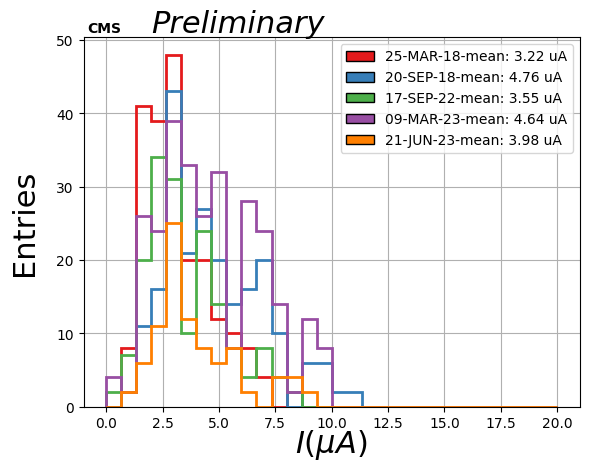

In [21]:
voltage = 7000
dates_ed = np.array(['25-MAR-18', "20-SEP-18", "17-SEP-22", "09-MAR-23", "21-JUN-23"])
RE_123 = pd.concat([select_endcap('RE+1', voltage, df_data = df_data_map),
                    select_endcap('RE+2', voltage, df_data = df_data_map),
                    select_endcap('RE+3', voltage, df_data = df_data_map)],
                    ignore_index=True)

plot(RE_123, dates_ed, bins=30)

In [22]:
RE123 = df_data_map[(df_data_map["Chamber_name"].str.find("RE+1")==0) | (df_data_map["Chamber_name"].str.find("RE+2")==0) | (df_data_map["Chamber_name"].str.find("RE+3")==0)]
RE123 = RE123[RE123["V_APPLIED"]==7000]
RE123_dates = RE123[RE123["START_DATE"].str.find("09-MAR-23")==0]
RE123

,DPID,DATE,START_DATE,STOP_DATE,V_APPLIED,AVG_IMON,Chamber_name
24618,142823,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 05.23.00.000000000 PM,25-MAR-18 05.32.19.000000000 PM,7000,1.7,RE+1_R3_CH33
24642,142823,20-SEP-18 07.49.07.000000000 PM,20-SEP-18 09.49.01.000000000 PM,20-SEP-18 09.58.41.000000000 PM,7000,1.9,RE+1_R3_CH33
24667,142824a,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 05.23.00.000000000 PM,25-MAR-18 05.32.19.000000000 PM,7000,2.2,RE+1_R3_CH29
24668,142824b,25-MAR-18 04.23.03.000000000 PM,25-MAR-18 05.23.00.000000000 PM,25-MAR-18 05.32.19.000000000 PM,7000,2.2,RE+2_R3_CH02
24715,142824a,20-SEP-18 07.49.07.000000000 PM,20-SEP-18 09.49.01.000000000 PM,20-SEP-18 09.58.41.000000000 PM,7000,3.2,RE+1_R3_CH29
...,...,...,...,...,...,...,...
88356,216670b,09-MAR-23 08.03.51.000000000 PM,11-MAR-23 03.44.14.000000000 PM,11-MAR-23 04.53.25.000000000 PM,7000,3.5,RE+3_R2_CH33
88383,216670a,09-MAR-2308.29.00.000000000 PM,23-MAR-23 07.05.35.000000000 AM,23-MAR-23 08.04.08.000000000 AM,7000,2.3,RE+2_R3_CH35
88384,216670b,09-MAR-2308.29.00.000000000 PM,23-MAR-23 07.05.35.000000000 AM,23-MAR-23 08.04.08.000000000 AM,7000,2.3,RE+3_R2_CH33
88403,216670a,21-JUN-23 10.54.59.000000000 AM,21-JUN-23 12.16.41.000000000 PM,21-JUN-23 12.30.46.000000000 PM,7000,2.7,RE+2_R3_CH35


There are multiple measurements for the same chamber on the same date, this is because the "DATE" is the same but the "START_DATE" is different.  

## RE-1, RE-2, RE-3

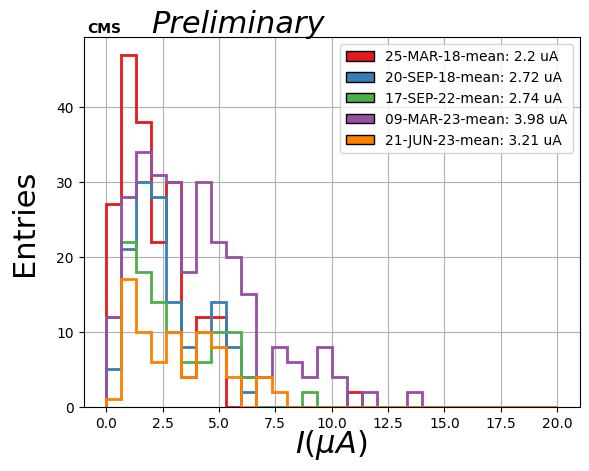

In [23]:
voltage = 7000
dates_ed = np.array(['25-MAR-18', "20-SEP-18", "17-SEP-22", "09-MAR-23", "21-JUN-23"])

RE_minus_123 = pd.concat([select_endcap('RE-1', voltage, df_data = df_data_map),
                    select_endcap('RE-2', voltage, df_data = df_data_map),
                    select_endcap('RE-3', voltage, df_data = df_data_map)],
                    ignore_index=True)

plot(RE_minus_123, dates_ed, bins=30)

## RE+4

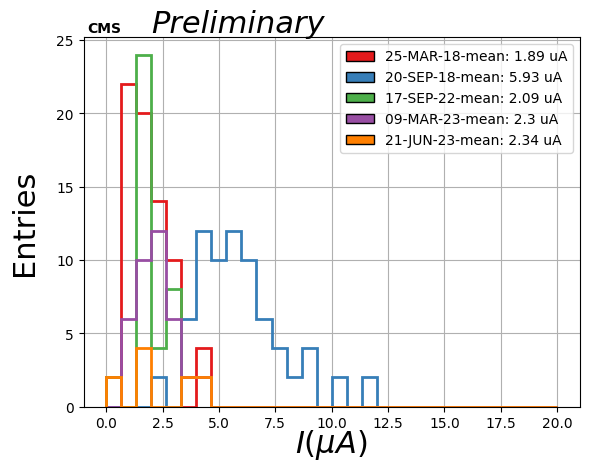

In [24]:
RE_4 = select_endcap('RE+4', voltage, df_data = df_data_map)
plot(RE_4, dates_ed, bins=30)

## RE-4

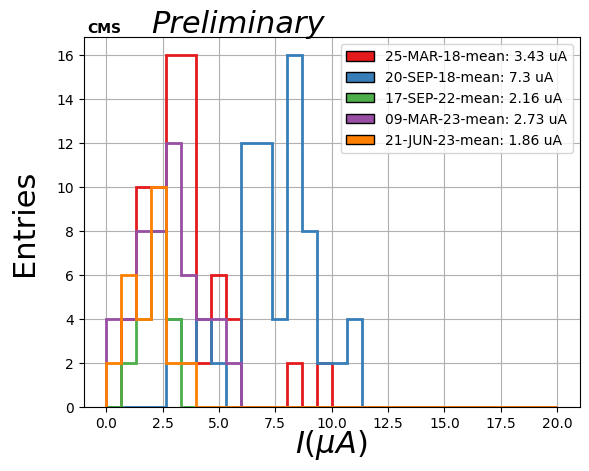

In [25]:
RE_minus_4 = select_endcap('RE-4', voltage, df_data = df_data_map)
plot(RE_minus_4, dates_ed, bins=30)

## W-2

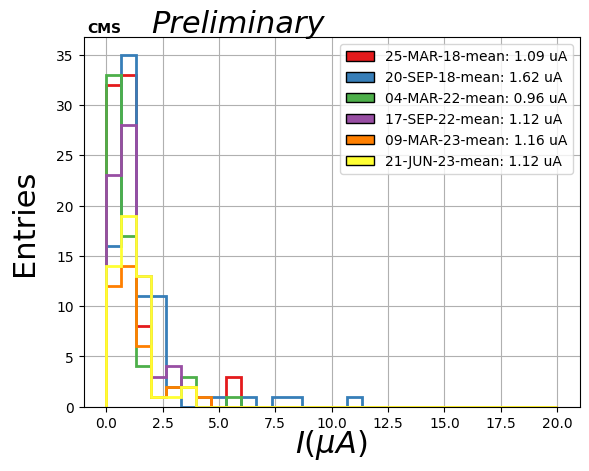

In [26]:
voltage = 7000

dates = np.array(['25-MAR-18', "20-SEP-18", "04-MAR-22", "17-SEP-22", "09-MAR-23", "21-JUN-23"])
Wminus2 = individual_wheel('W-2', voltage, df_data = df_data_map)
plot(Wminus2, dates, bins=30)

## W-1

There is no data available for: 04-MAR-22


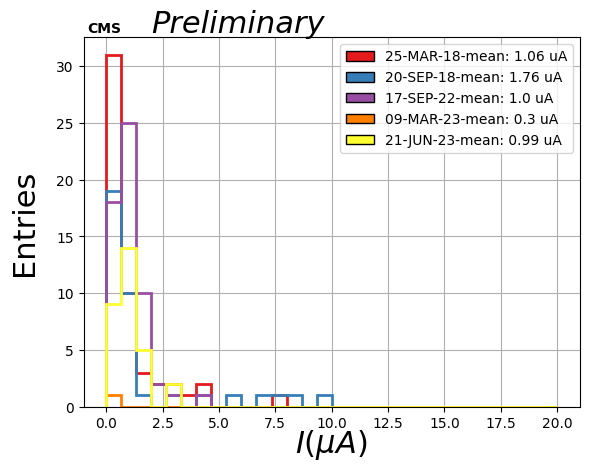

In [27]:
Wminus1 = individual_wheel('W-1', voltage, df_data = df_data_map)
plot(Wminus1, dates, bins=30)

## W0

There is no data available for: 04-MAR-22
There is no data available for: 09-MAR-23


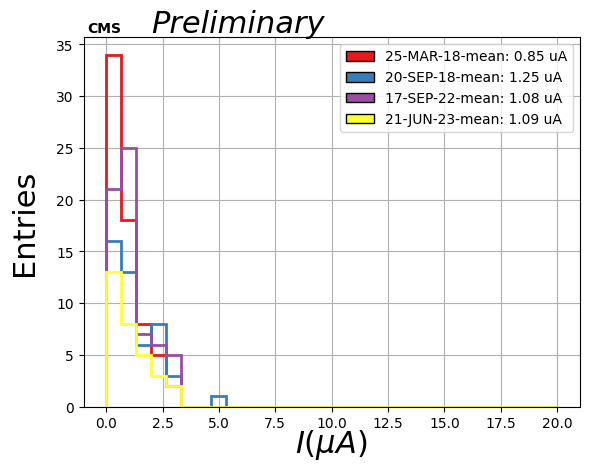

In [28]:
W0 = individual_wheel('W0', voltage, df_data = df_data_map)
plot(W0, dates, bins=30)

## W+1

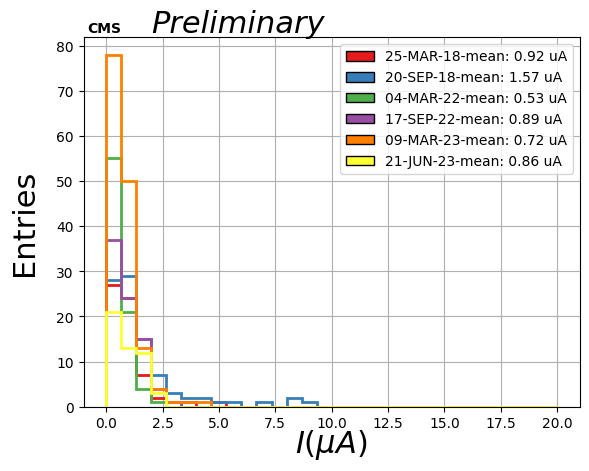

In [29]:
Wplus1 = individual_wheel('W+1', voltage, df_data = df_data_map)
plot(Wplus1, dates, bins=30)

## W+2

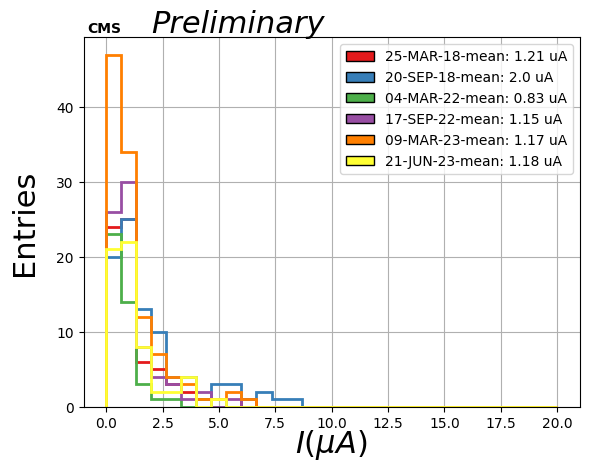

In [30]:
Wplus2 = individual_wheel('W+2', voltage, df_data = df_data_map)
plot(Wplus2, dates, bins=30)

# Searching duplicates in histograms

In [31]:
voltage = 7000
dates_ed = np.array(['25-MAR-18', "20-SEP-18", "17-SEP-22", "09-MAR-23", "21-JUN-23"])
RE_1 = select_endcap('RE+1', voltage, df_data = df_data_map)
Re_minus_1 = select_endcap('RE-1', voltage, df_data = df_data_map)
RE_2 = select_endcap('RE+2', voltage, df_data = df_data_map)
Re_minus_2 = select_endcap('RE-2', voltage, df_data = df_data_map)
RE_3 = select_endcap('RE+3', voltage, df_data = df_data_map)
Re_minus_3 = select_endcap('RE-3', voltage, df_data = df_data_map)

In [32]:
def plot_unique_chambers_RE(region, name, maximum):
  n1w_m2, n1w_m2u =len(region[region['DATE'].str.find("25-MAR-18")==0]), len(region[region['DATE'].str.find("25-MAR-18")==0]["Chamber_name"].unique())
  n2_1w_m2, n2_1w_m2u = len(region[region['DATE'].str.find("27-JUL-18")==0]), len(region[region['DATE'].str.find("27-JUL-18")==0]["Chamber_name"].unique())
  n2w_m2, n2w_m2u = len(region[region['DATE'].str.find("20-SEP-18")==0]), len(region[region['DATE'].str.find("20-SEP-18")==0]["Chamber_name"].unique())
  n3w_m2, n3w_m2u =len(region[region['DATE'].str.find("04-MAR-22")==0]), len(region[region['DATE'].str.find("04-MAR-22")==0]["Chamber_name"].unique())
  n4w_m2, n4w_m2u =len(region[region['DATE'].str.find("17-SEP-22")==0]), len(region[region['DATE'].str.find("17-SEP-22")==0]["Chamber_name"].unique())
  n5w_m2, n5w_m2u =len(region[region['DATE'].str.find("09-MAR-23")==0]), len(region[region['DATE'].str.find("09-MAR-23")==0]["Chamber_name"].unique())
  n6w_m2, n6w_m2u =len(region[region['DATE'].str.find("21-JUN-23")==0]), len(region[region['DATE'].str.find("21-JUN-23")==0]["Chamber_name"].unique())

  times_W_minus_2u = {"25-MAR-18": n1w_m2u, "27-JUL-18": n2_1w_m2u,
                      "20-SEP-18" : n2w_m2u, "04-MAR-22": n3w_m2u,
          "17-SEP-22" : n4w_m2u, "09-MAR-23":n5w_m2u, "21-JUN-23": n6w_m2u}
  times_W_minus_2 = {"25-MAR-18": n1w_m2 , "27-JUL-18": n2_1w_m2,
                     "20-SEP-18" : n2w_m2, "04-MAR-22":n3w_m2,
          "17-SEP-22" : n4w_m2, "09-MAR-23":n5w_m2, "21-JUN-23": n6w_m2}
  plt.figure(figsize=(12,10))
  labels = list(times_W_minus_2u.keys())
  x = np.arange(len(labels))

  values1 = list(times_W_minus_2u.values())
  values2 = list(times_W_minus_2.values())

  bar_width = 0.35

  plt.bar(x - bar_width/2, values1, bar_width, label='Total unique chambers analyzed', color='b', align='edge')
  plt.bar(x + bar_width/2, values2, bar_width, label='Total chambers analyzed', color='g', align='edge')
  plt.axhline(y=maximum, color="r", label="Total Chambers", ls ="--")
  plt.title(f"Chambers analyzed in {str(name)} region")
  plt.xlabel('dates')
  plt.ylabel('Entries')
  plt.xticks(x, labels, rotation=45)
  plt.legend()

  plt.show()

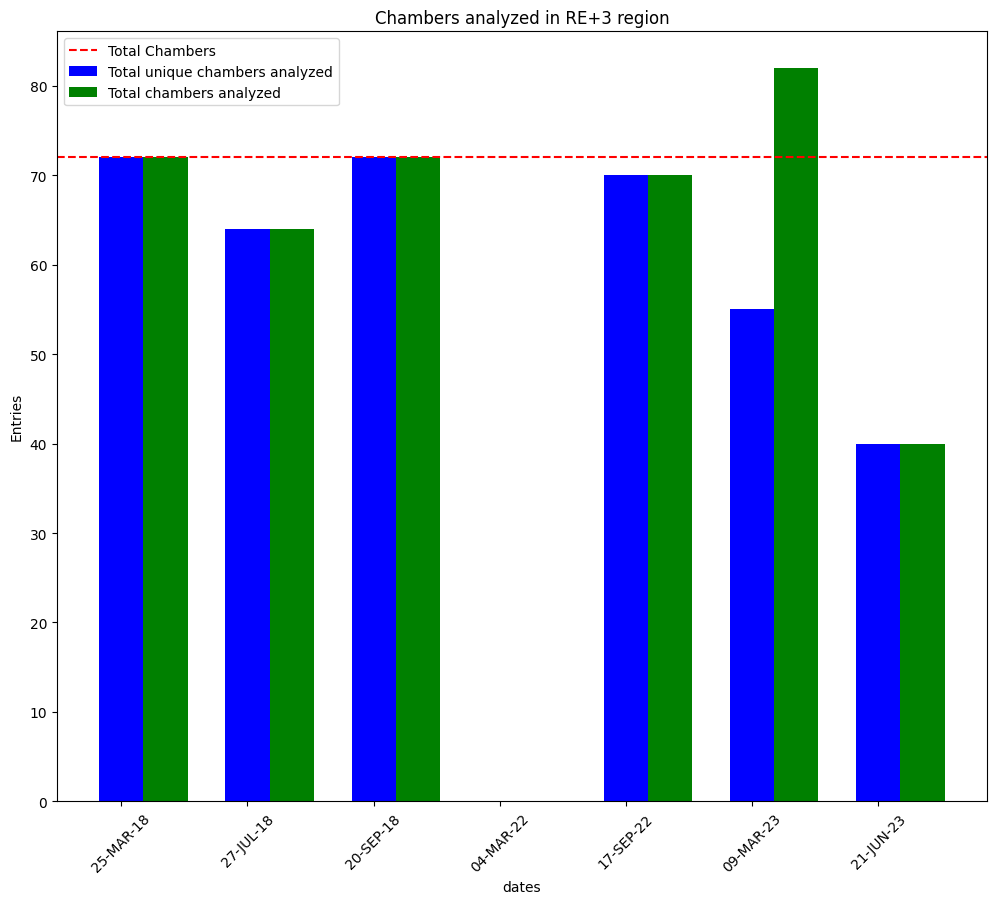

In [33]:
#You can modify the region to be plotted in this section
plot_unique_chambers_RE(RE_3, "RE+3", 72)

# ANALYZING DATES

In [34]:
import re
import pandas as pd

pattern_date = r'(\b\d{2}-[A-Z]{3}-\d{2}\b)'

global_date = df_data_map["DATE"].str.extract(pattern_date, expand=False)

global_date

0        27-JUL-18
1        27-JUL-18
2        27-JUL-18
3        27-JUL-18
4        27-JUL-18
           ...    
88540    21-JUN-23
88541    21-JUN-23
88542    21-JUN-23
88543    21-JUN-23
88544    21-JUN-23
Name: DATE, Length: 88545, dtype: object

In [35]:
global_date.value_counts()

27-JUL-18    22644
20-SEP-18    20763
25-MAR-18    15759
17-SEP-22     9708
21-JUN-23     5217
09-MAR-23     4284
04-MAR-22     2383
Name: DATE, dtype: int64

In [36]:
initial_dates = df_data_map["START_DATE"].str.extract(pattern_date, expand=False)

initial_dates.value_counts()

27-JUL-18    22644
20-SEP-18    20763
25-MAR-18    15758
17-SEP-22     9708
21-JUN-23     5217
23-MAR-23     3411
11-MAR-23     2049
07-MAR-22     1081
12-MAR-23     1044
09-MAR-23      707
05-MAR-22      558
06-MAR-22      558
04-MAR-22      186
28-MAR-18        1
Name: START_DATE, dtype: int64

Text(0, 0.5, 'Entries')

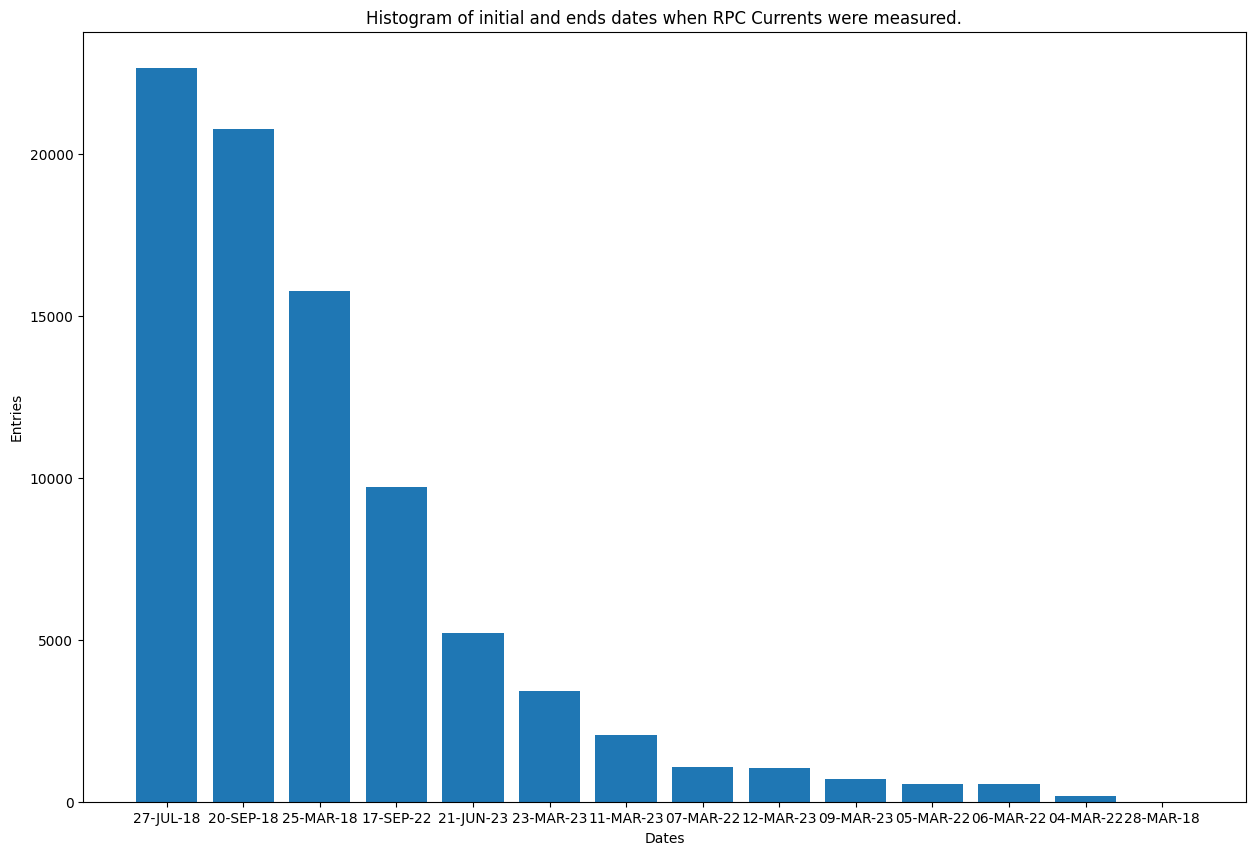

In [37]:
plt.figure(figsize=(15,10))
plt.bar(initial_dates.value_counts().index, initial_dates.value_counts())
plt.title("Histogram of initial and ends dates when RPC Currents were measured.")
plt.xlabel("Dates")
plt.ylabel("Entries")

Text(0, 0.5, 'Entries')

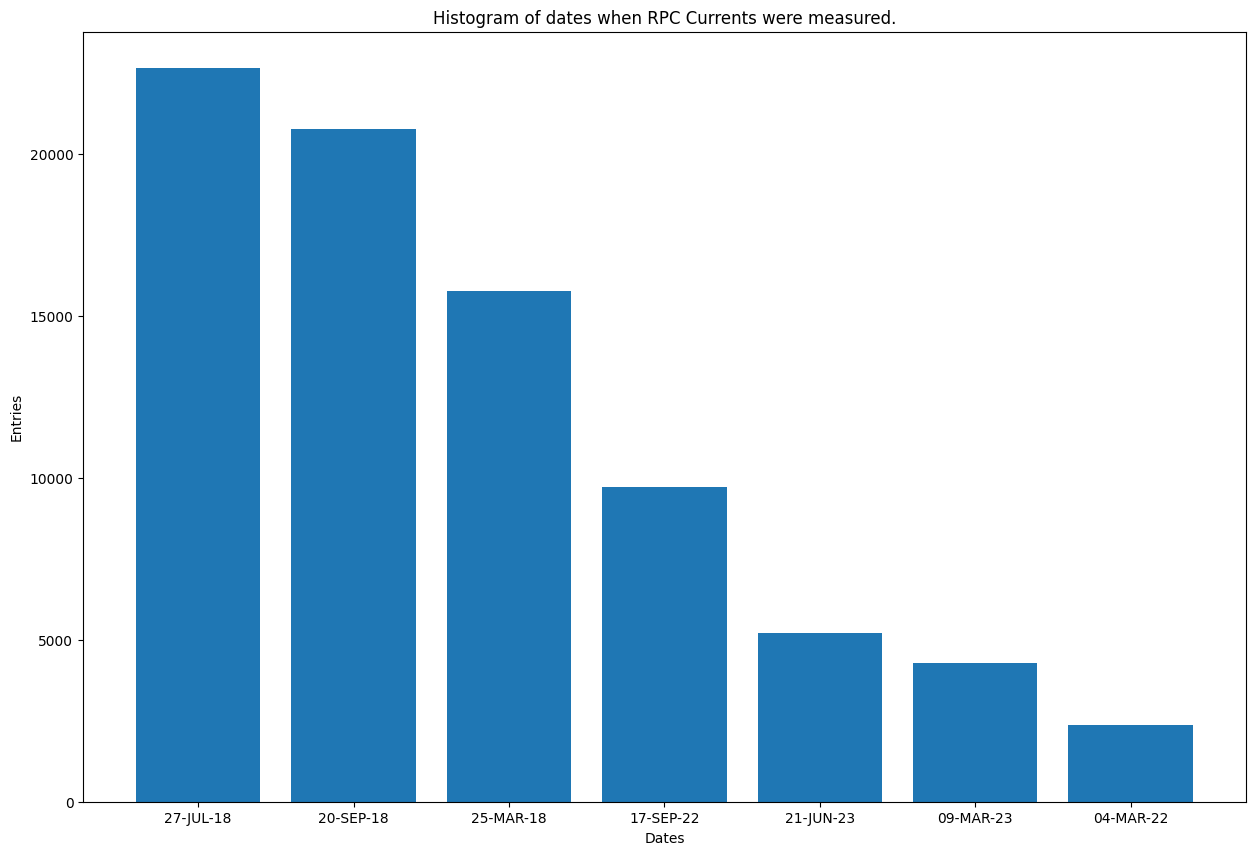

In [38]:
plt.figure(figsize=(15,10))
plt.bar(global_date.value_counts().index, global_date.value_counts())
plt.title("Histogram of dates when RPC Currents were measured.")
plt.xlabel("Dates")
plt.ylabel("Entries")